# Sensor self-noise 
Based on Adam Ringler (USGS) code

## Import ObsPy module

In [1]:
from obspy.core import UTCDateTime, read, Stream
from obspy.signal.spectral_estimation import get_nlnm, get_nhnm
from obspy import read_inventory

## Import other modules

In [2]:
# version output
import obspy as ob
print("# obspy version = ",ob.__version__)
import numpy as np
print("# numpy version = ",np.__version__)

import scipy as sp
from scipy import signal
print("# scipy version = ",sp.__version__)

import matplotlib as mpl
import matplotlib.pyplot as plt
print("# matplotlib version = ",mpl.__version__)

# obspy version =  1.2.2
# numpy version =  1.19.1
# scipy version =  1.5.2
# matplotlib version =  3.3.1


## Figure and font sizes

In [3]:
#plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['figure.figsize'] = 16, 10

# font size
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

#SMALL_SIZE = 32
#MEDIUM_SIZE = 32
#BIGGER_SIZE = 36

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Seismic data and reponse files

In [4]:
data1 = "http://ncedc.org/ftp/outgoing/taira/WQC/BKS.BK.HHZ.00.D.2019.230"
data2 = "http://ncedc.org/ftp/outgoing/taira/WQC/BK80.BK.HHZ.00.D.2019.230"
data3 = "http://ncedc.org/ftp/outgoing/taira/WQC/BK82.BK.HHZ.00.D.2019.230"

resp1 = "http://ncedc.org/ftp/pub/doc/BK.info/BK.FDSN.xml/BK.BKS.xml"
resp2 = "http://ncedc.org/ftp/outgoing/taira/WQC/BK.BK80.xml"
resp3 = "http://ncedc.org/ftp/outgoing/taira/WQC/BK.BK82.xml"


## Set parameters


In [5]:
pre_filt = [0.0003, 0.0005, 45, 50] # filtering range when instrment reponse is corrected

In [6]:
decifactor_1 = 4 # 100sps -> 25 sps
decifactor_2 = 4 # 100sps -> 25 sps
decifactor_3 = 4 # 100sps -> 25 sps

In [8]:
# time window for incoherent noise estimate
start_time = UTCDateTime("2019-08-18T08:11:00")
tw_trim = 36000 # sec 

In [9]:
# data points and overlap for Welch method
data_points = 65536 # number of data points  2^16 
overlap = (7.0/8.0) # overlap 


In [10]:
# frequency range of figure
xmin = 0.0005 # H
xmax = 10 # Hz


In [11]:
pngOUTOPT = 1 # save plot as png
pngOUT_fi = "incoherent_noise.png" # png name


In [12]:
# color codes for three seismic data
#CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
#                  '#f781bf', '#a65628', '#984ea3',
#                  '#999999', '#e41a1c', '#dede00']
color3="#377eb8"
color2="#a65628"
color1="#e41a1c"



## Read seismic data


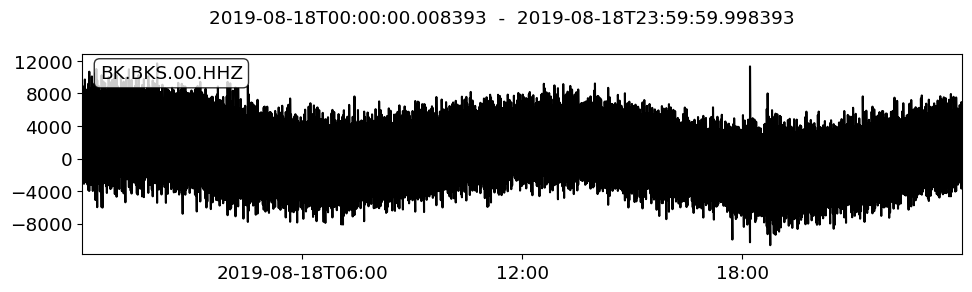

In [13]:
st1 = read(data1)
_plot = st1.plot(size=(1000,300))

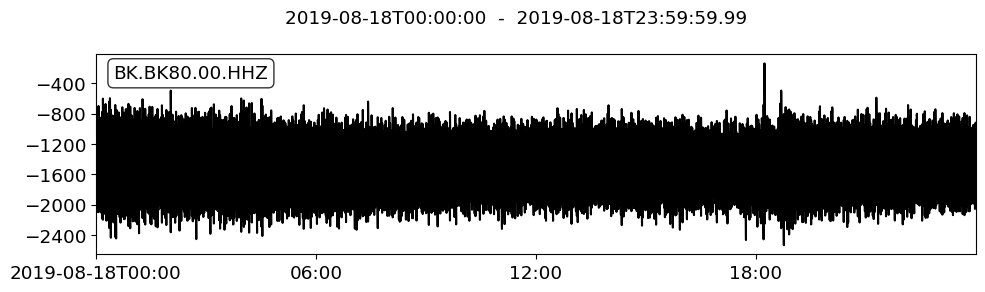

In [14]:
st2 = read(data2)
_plot = st2.plot(size=(1000,300))

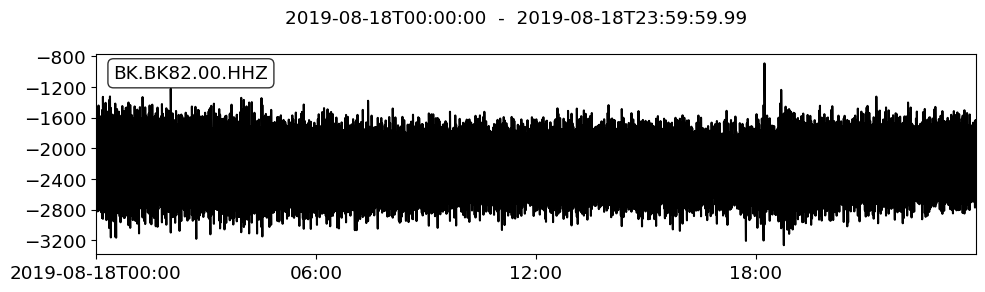

In [15]:
st3 = read(data3)
_plot = st3.plot(size=(1000,300))

## Read response file


In [16]:
## Read seismic data
inv1 =read_inventory(resp1)
#print(inv1)

In [17]:
## Read seismic data
inv2 =read_inventory(resp2)
#print(inv2)

In [18]:
## Read seismic data
inv3 =read_inventory(resp3)
#print(inv2)

## Correct instrument response


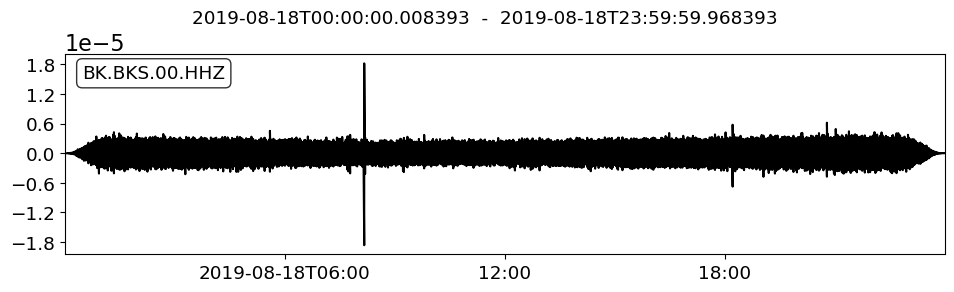

In [19]:
st1.detrend() # remove linear trend
st1.detrend("demean") # demean
st1.taper(0.05) # cosin taper

st1 = st1.remove_response( output="ACC", pre_filt=pre_filt, water_level=None, inventory=inv1)
# decimation
st1.decimate(factor=decifactor_1, strict_length=False)

_plot = st1.plot(size=(1000,300))
#print(st1)

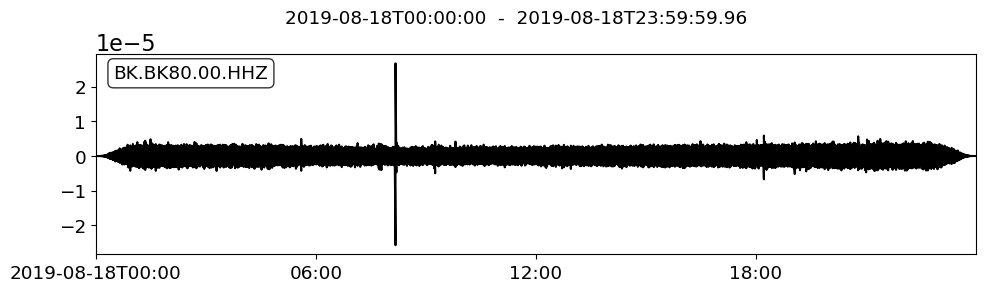

In [20]:
st2.detrend() # remove linear trend
st2.detrend("demean") # demean
st2.taper(0.05) # cosin taper

st2 = st2.remove_response( output="ACC", pre_filt=pre_filt, water_level=None, inventory=inv2)
# decimation
st2.decimate(factor=decifactor_2, strict_length=False)

_plot = st2.plot(size=(1000,300))

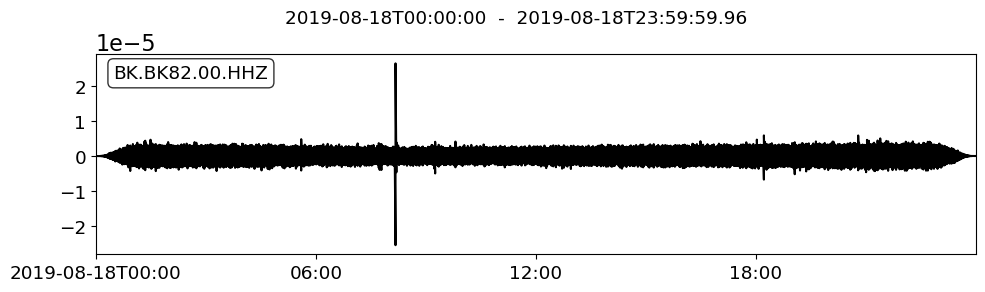

In [21]:
st3.detrend() # remove linear trend
st3.detrend("demean") # demean
st3.taper(0.05) # cosin taper

st3 = st3.remove_response( output="ACC", pre_filt=pre_filt, water_level=None, inventory=inv3)
# decimation
st3.decimate(factor=decifactor_3, strict_length=False)

_plot = st3.plot(size=(1000,300))

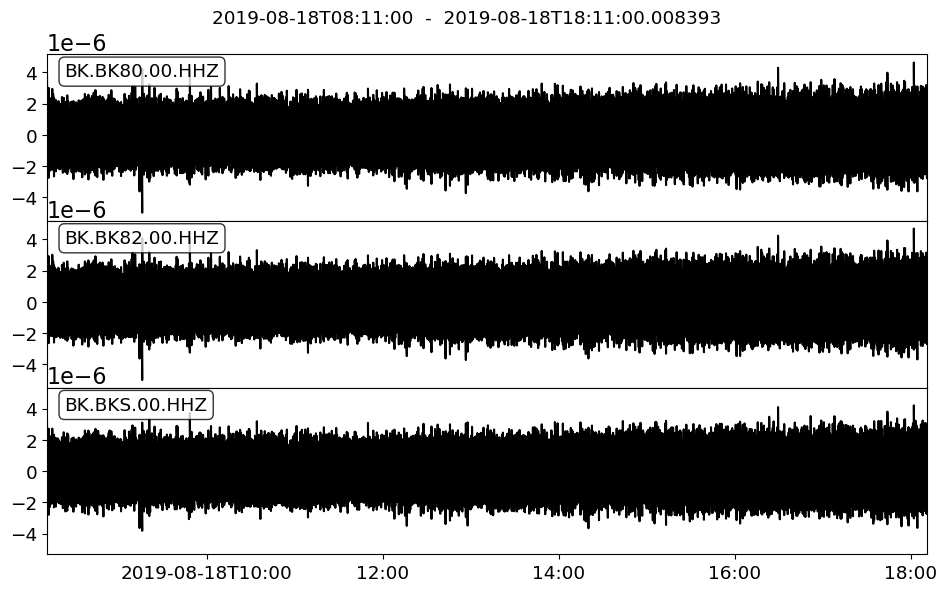

In [22]:
st = st1.copy() + st2.copy() + st3.copy()
st.trim(start_time, start_time + tw_trim)
_plot = st.plot(size=(1000,600))

## Compute incoherent−noise with Sleeman method (three stations)

In [23]:
nperseg = data_points
noverlap = int(data_points*overlap)
delta = st[0].stats.delta
fre1_sp, p11_sp = signal.welch(st[0], 1/delta, nperseg=nperseg, noverlap=noverlap)
fre1_sp, p22_sp = signal.welch(st[1], 1/delta, nperseg=nperseg, noverlap=noverlap)
fre1_sp, p33_sp = signal.welch(st[2], 1/delta, nperseg=nperseg, noverlap=noverlap)

#f, Pxy = signal.csd(x, y, fs, nperseg=1024)

fre1_sp, p21_sp = signal.csd(st[1], st[0], 1/delta, nperseg=nperseg, noverlap=noverlap)
fre1_sp, p13_sp = signal.csd(st[0], st[2], 1/delta, nperseg=nperseg, noverlap=noverlap)
fre1_sp, p23_sp = signal.csd(st[1], st[2], 1/delta, nperseg=nperseg, noverlap=noverlap)


n11_sp = (p11_sp - p21_sp*p13_sp/p23_sp)
n22_sp = (p22_sp - np.conjugate(p23_sp)*p21_sp/np.conjugate(p13_sp))
n33_sp = (p33_sp - p23_sp*np.conjugate(p13_sp)/p21_sp)


## Plotting incoherent−noise

/Users/taira/opt/anaconda3/envs/netops/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/taira/opt/anaconda3/envs/netops/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/taira/opt/anaconda3/envs/netops/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


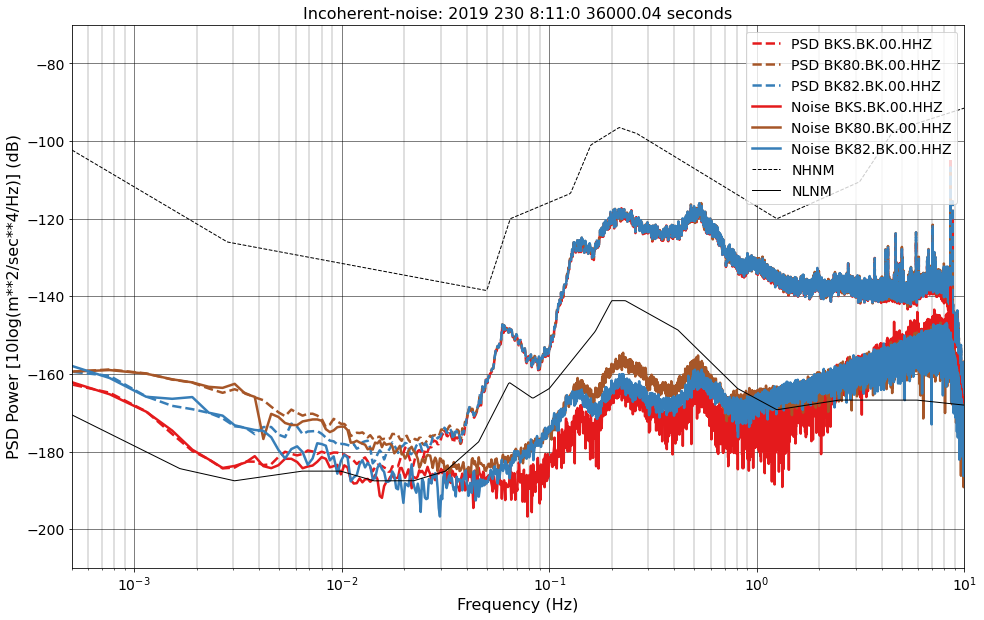

In [24]:

xout_sp = fre1_sp

st1_sncl = st[0].stats.station + '.' + st[0].stats.network + '.' + st[0].stats.location + "." + st[0].stats.channel
st2_sncl = st[1].stats.station + '.' + st[1].stats.network + '.' + st[1].stats.location + "." + st[1].stats.channel
st3_sncl = st[2].stats.station + '.' + st[2].stats.network + '.' + st[2].stats.location + "." + st[2].stats.channel

plt.plot(xout_sp,10*np.log10(p11_sp),color=color1,linestyle='dashed',linewidth = 2.5,label='PSD ' + st1_sncl)
plt.plot(xout_sp,10*np.log10(p22_sp),color=color2,linestyle='dashed',linewidth = 2.5,label='PSD ' + st2_sncl)
plt.plot(xout_sp,10*np.log10(p33_sp),color=color3,linestyle='dashed',linewidth = 2.5,label='PSD ' + st3_sncl)

plt.plot(xout_sp,10*np.log10(n11_sp),color=color1,linewidth = 2.5,label='Noise '+st1_sncl)
plt.plot(xout_sp,10*np.log10(n22_sp),color=color2,linewidth = 2.5,label='Noise '+st2_sncl)
plt.plot(xout_sp,10*np.log10(n33_sp),color=color3,linewidth = 2.5,label='Noise '+st3_sncl)


plt.grid(True)
plt.xscale("log")
plt.xlim(xmin,xmax)

plt.ylim(-210,-70)


plt.grid(which='major',color='black',linestyle='-',linewidth = 0.5)
plt.grid(which='minor',color='black',linestyle='-',linewidth = 0.25)

plt.ylabel("PSD Power [10log(m**2/sec**4/Hz)] (dB)", fontsize=16)

plt.title('Incoherent-noise: ' + str(st[0].stats.starttime.year) + ' ' + str(st[0].stats.starttime.julday) + ' ' +  \
str(st[0].stats.starttime.hour) + ':' + str(st[0].stats.starttime.minute) + ':' + str(st[0].stats.starttime.second) + ' ' +  \
str(st[0].stats.npts*delta) + ' seconds')
    

plt.tick_params(labelsize=14)

model_periods, high_noise = get_nhnm()
plt.plot(1/model_periods, high_noise, color='black',linestyle='dashed',linewidth = 1.0,label='NHNM')

model_periods, low_noise = get_nlnm()
plt.plot(1/model_periods, low_noise, color='black',linestyle='solid',linewidth = 1.0,label='NLNM')

plt.xlabel("Frequency (Hz)", fontsize=16)



plt.legend(loc="upper left", fontsize=14) 
plt.legend(loc="upper right", fontsize=14) 

if pngOUTOPT:
    plt.savefig(pngOUT_fi)
